# The thermodynamics of ideal and regular solution models 

*Authors: Enze Chen (University of California, Berkeley)*

This is an interactive notebook for playing around with the temperature and interaction parameter $\beta$ and observing the effect on the resulting free energy curves of a binary ideal or regular solution. Following that, there is a small section for readers to complete their own code to generate the phase diagram for an ideal or regular solution model. There are [similar demos](http://www.learncheme.com/simulations/thermodynamics/thermo-2/effect-of-temperature-on-partial-miscibility) available online, but I couldn't find one that was interactive in this way and written in Python. Thermodynamics is fairly math-heavy and a tough subject to master, but I believe having quality visualizations can have a large, positive impact on your learning. I hope you will find this notebook functional, readable, and educational.

## Usage

### Part 1
In the first half of this notebook, everything is completed for you and you just have to run it. To execute each cell of the notebook and automatically advance to the next cell, press `Shift+Enter`. Or you can click `Run All` in the menu at the top. When done successfully, you'll see a widget slider pop up that you can adjust and observe the changes.

### Part 2
In the second half, there is one section for you to complete the code in order to construct the resulting phase diagram. This is delineated with the dashed lines as follows, and you should **only change what's inside**. You don't have to edit the text or code anywhere else.
```python
# ---------------------- #
# YOUR CODE HERE

# ---------------------- #
```
If you edit the code in a cell, just press `Shift+Enter` to run it again. You have to execute **all** the code cells in this notebook from top to bottom (so don't skip around). A number `[#]` will appear to the left of the code cell once it's done executing. When done successfully, you'll be able to generate a lens-shaped phase diagram at the very end.

## Acknowledgements
I thank [Prof. Gerbrand Ceder](https://mse.berkeley.edu/people_new/ceder/) for teaching MATSCI 201A: Thermodynamics and Phase Transformations in Solids and my advisor [Prof. Mark Asta](https://mse.berkeley.edu/people_new/asta/) for conceiving this idea, providing preliminary scripts and data, and encouraging me in my education-related pursuits. Interactivity is enabled with the [`ipywidgets`](https://ipywidgets.readthedocs.io/en/stable/) library. An interactive version of this notebook can be found online at [Google Colaboratory](https://colab.research.google.com/github/enze-chen/learning_modules/blob/master/mse/Thermo_solution_models.ipynb).

## Important equations

We know from thermodynamics that in general,

$$ \Delta G = \Delta H - T \Delta S$$

where $\Delta H$ is the enthalpy, $T$ is the temperature, and $\Delta S$ is the entropy. Hopefully this is ingrained in your head by now.

In the regular solution model, we have an interaction term in the enthalpy given by the $\beta$ parameter, where

$$ \Delta H_{\text{mix}} = \beta x(1-x) $$

and $x$ is the atomic fraction. For ideal solutions, we can simply set $\beta = 0$. The entropy of mixing is given by

$$ \Delta S_{\text{mix}} = -R \left[ x \ln x + (1-x) \ln(1-x) \right] $$

Furthermore, we'll assume for this demo that the free energies of the pure solid phases are $0$ (reference) and that the molar free energy differences between the liquid and solid phases at these pure endpoints can be approximated by

$$ \Delta G_m^{0}(T) = \Delta G^{s \rightarrow l}(T) = \Delta S_m^0 [T_m - T] $$


## Assumptions
* I assumed that the two curves would be mostly convex for my optimization routine.
* I assumed that there will only be one common tangent (i.e. no "boomerang" phase diagrams).
* I assumed that self-common tangents are mostly horizontal (i.e. curve is not "tilted").

## Known issues
* It doesn't have great safeguards against index-out-of-bounds errors, which will happen if you put absurd quantities for the $\beta$ parameter. Please be gentle. ❤

## Python library imports

These are all the required Python libraries.

In [1]:
# General libraries
import warnings
warnings.filterwarnings('ignore')  # please do as I say, not as I do

# Scientific computing libraries
import numpy as np
from scipy.misc import derivative
import matplotlib.pyplot as plt
%matplotlib inline

# Interactivity libraries
from ipywidgets import interact, interact_manual, fixed, \
                       IntSlider, FloatSlider, FloatLogSlider, \
                       Button, Layout

## Analytical functions

Here are the theoretical curves for the Gibbs free energy ($\Delta G$) of the solid and liquid phases, with data taken from a certain material $A$ and a certain material $B$. We define $x$ to be the atomic fraction of $B$, which substitutes on the $A$ sites. $\beta$ is the interaction parameter for the regular solution model, and has a default value of $0$ (ideal solution).

In [2]:
def curve_s(x, T, beta_s=0, R=8.314):
    """This function plots the Gibbs free energy curve for the solid solution.
    
    Args:
        x (numpy.darray): An array of atomic fractions of B.
        T (float): The temperature in Kelvin.
        beta_s (float): The interaction parameter in J/mol.
        R (float): The ideal gas constant in J/(mol*K).
        
    Returns:
        G_s (numpy.darray): An array of Gibbs free energy values in kJ/mol.    
    """
    S_mix = -R * (np.multiply(x, np.log(x)) + np.multiply(1 - x, np.log(1 - x)))
    H_mix = beta_s * np.multiply(x, 1 - x)
    G_s = -T * S_mix + H_mix
    return G_s / 1000


def curve_l(x, T, beta_l=0, R=8.314):
    """This function plots the Gibbs free energy curve for the liquid solution.
    
    Args:
        x (numpy.darray): An array of atomic fractions of B.
        T (float): The temperature in Kelvin.
        beta_l (float): The interaction parameter in J/mol.
        R (float): The ideal gas constant in J/(mol*K).
        
    Returns:
        G_l (numpy.darray): An array of Gibbs free energy values in kJ/mol.    
    """
    S_A, S_B = (52.7, 59.9)
    T_A, T_B = (1890 + 273, 1205 + 273)
    G_A = S_A * (T_A - T)
    G_B = S_B * (T_B - T)
    S_mix = -R * (np.multiply(x, np.log(x)) + np.multiply(1 - x, np.log(1 - x)))
    H_mix = beta_l * np.multiply(x, 1 - x)
    G_l = x * G_B + (1 - x) * G_A - T * S_mix + H_mix
    return G_l / 1000

## Constructing the common tangent

There are many ways one could go about doing this. I've seen people in the past do a brute force enumeration (\*shudder\*). John Dagdelen suggests a Legendre transform (nifty!). I got really excited about trying gradient descent optimization (yeet). Eventually, after much Googling and consideration, I went with something simple and relatively fast, inspired from [this StackOverflow answer](https://stackoverflow.com/a/10271179). The procedure is as follows:

1. Using `scipy`, compute a derivative of curve 1, $\Delta G^s$, and store this for later use.
1. Pick the minimum of curve 1 as an initial guess as the common tangent will be close to there.
1. Using the derivative and coordinates, construct the tangent line at the minimum.
1. Extend the tangent line and see if it intersects curve 2, $\Delta G^l$.
    1. **If so**, shift the tangent point *left* on curve 1 and continue building tangent lines of decreasing slope.
        1. Repeat step 4.
        1. As soon as an extended tangent line *misses* curve 2, **stop**.
    1. **If not**, shift the tangent point right on curve 1 and continue building tangent lines of increasing slope.
        1. Repeat step 4.
        1. As soon as an extended tangent line *intersects* curve 2, **stop**.
1. Identify where the common tangent intersects the two curves so we only plot that portion.

In [3]:
def common_tangent(x, y1, y2, T, beta_s=0):
    """This function calculates the common tangent of two convex curves.
    
    Args:
        x (numpy.darray): An array of atomic fractions of B.
        y1 (numpy.darray): y values for curve 1.
        y2 (numpy.darray): y values for curve 2.
        T (float): The temperature in Kelvin.
        beta_s (float): The interaction parameter for the solid solution.
        
    Returns:
        line (numpy.darray): y values for the common tangent.
        idmin (int): Index of the x-coordinate of the first tangent point.
        idmax (int): Index of the x-coordinate of the second tangent point.
    """
    # Compute a derivative
    dx = 1e-3
    dy1 = derivative(func=curve_s, x0=x, dx=dx, args=(T, beta_s,))

    # Make an initial guess at the minimum of curve 1
    n = len(x)
    idmin, idmax = (0, n)
    idx = np.argmin(y1)
    yp = y1[idx]
    xp = x[idx]
    dyp = dy1[idx]

    # Construct the tangent line and count intersections with curve 2
    line = dyp * x + yp - dyp * xp
    diff = np.diff(np.sign(y2 - line))
    nnz = np.count_nonzero(diff)

    # They're the same curve. Used for finding miscibility gap
    if np.linalg.norm(y1 - y2) < 1e-4:
        idmin = np.argmin(y1[:int(n/2)])
        idmax = np.argmin(y1[int(n/2):]) + int(n/2)

    # If the tangent line intersects curve 2, shift tangent point to the left
    elif nnz >= 1:
        while nnz >= 1:
            idx -= 1
            # try-except to avoid an out-of-bounds error 
            try:
                yp = y1[idx]
                xp = x[idx]
                dyp = dy1[idx]
                line = dyp * x + yp - dyp * xp
                diff = np.diff(np.sign(y2 - line))
                nnz = np.count_nonzero(diff)
            except:
                break
            if diff.any():
                # Assign left and right indices of the tangent points
                # Here we do it each time because once we miss, we can't go back
                idmax = np.nonzero(diff)[0][0]
        idmin = idx

    # If the tangent line misses curve 2, shift tangent point to the right
    elif nnz < 1:
        while nnz < 1:
            idx += 1
            # try-except to avoid an out-of-bounds error 
            try:
                yp = y1[idx]
                xp = x[idx]
                dyp = dy1[idx]
                line = dyp * x + yp - dyp * xp
                diff = np.diff(np.sign(y2 - line))
                nnz = np.count_nonzero(diff)
            except:
                break
        # Assign left and right indices of the tangent points
        idmin = idx
        idmax = np.nonzero(diff)[0][0]
    
    # Return a tuple
    return (line, idmin, idmax)

## Widget function

Our widget will call `plot_Gx()` each time we interact with it. This function calls `curve_s()` and `curve_l()` to get the solid and liquid free energy curves, respectively. It then calls the `common_tangent()` function above to calculate the common tangent to the two curves. The rest of the function handles the plotting, where I specifically chose to lock the $y$-axis to emphasize how much $\Delta G^l$ changes as a function of temperature compared to $\Delta G^s$.

In [4]:
def plot_Gx(T=1800, beta_s=0, beta_l=0):
    """This function is called by the widget to perform the plotting based on inputs.
    
    Args:
        T (float): The temperature in Kelvin.
        beta_s (float): The interaction parameter for solids in J/mol.
        beta_l (float): The interaction parameter for liquids in J/mol.
        
    Returns:
        None, but a pyplot is displayed.
    """
    # For the given temperature, calculate the curves and common tangent
    n = int(1e4)
    xmin, xmax = (0.001, 0.999)
    x = np.linspace(xmin, xmax, n)
    y_s = curve_s(x, T, beta_s)
    y_l = curve_l(x, T, beta_l)
    line, idmin, idmax = common_tangent(x, y_s, y_l, T, beta_s)

    # Mostly plot settings for visual appeal
    plt.rcParams.update({'figure.figsize':(8,6), 'font.size':20, \
                         'lines.linewidth':4, 'axes.linewidth':2})
    fig, ax = plt.subplots()
    ax.plot(x, y_s, c='C0', label='solid')
    ax.plot(x, y_l, c='C1', label='liquid')
    ax.plot(x[idmin:idmax], line[idmin:idmax], c='k', lw=5, ls='-.')
    ax.tick_params(top=True, right=True, direction='in', length=10, width=2)
    ax.set_xlim(0, 1)
    ax.set_ylim(-39, 19)
    ax.set_xlabel(r'$x_{B}$')
    ax.set_ylabel(r'$\Delta G$ (kJ/mol)')
    ax.set_title('Gibbs free energy at T = {} K'.format(T), fontsize=18)
    plt.legend()
    plt.show()

We create each slider individually for readability and customization.

In [5]:
mystyle = {'description_width':'130px'}
mylayout = layout=Layout(width='400px', height='30px')

T_widget = IntSlider(value=1800, min=1400, max=2200, step=50, \
                     description='Temperature (K)', readout_format='d', \
                     style=mystyle, layout=mylayout, continuous_update=False)

bs_widget = IntSlider(value=0, min=-1e4, max=1e4, step=250, \
                      description=r'$\beta_s$ parameter (J/mol)', readout_format='d', \
                      style=mystyle, layout=mylayout, continuous_update=False)

bl_widget = IntSlider(value=0, min=-1e4, max=1e4, step=250, \
                      description=r'$\beta_l$ parameter (J/mol)', readout_format='d', \
                      style=mystyle, layout=mylayout, continuous_update=False)

Each time you release your mouse, the plot will automatically update! This is because we specified `continuous_update=False` in the constructor.

In [6]:
interact(plot_Gx, T=T_widget, beta_s=bs_widget, beta_l=bl_widget);

interactive(children=(IntSlider(value=1800, continuous_update=False, description='Temperature (K)', layout=Lay…


--------------------------------------------

--------------------------------------------

--------------------------------------------


## Creating the phase diagram

Now that we have everything set up, it's your job to finish off the notebook. This probably sounds silly, but before taking MATSCI 201A, it did not occur to me that the data above actually correspond to a phase diagram. I guess that just wasn't emphasized in my undergraduate studies or I simply dozed off. **/shrug**

But they do! Specifically, the common tangent indicates, for a specific $T$, the region of solid-liquid coexistence. The two tangent points on the solid and liquid curves lie on the solidus and liquidus curves, respectively. Knowing this, we'll now loop through a few values of $T$ (`Ts`) to obtain a set of $x$-coordinates and then construct the phase diagram from them.

In [7]:
# Enumerate the temperatures we want to calculate phase boundaries at. 
# 9 points give enough detail without being too computationally expensive.
Ts = np.linspace(1480, 2152, 9)

**TODO**: Your job is to figure out where the common tangent points are for each value of $T$. If you didn't change any of the above data or code, you may assume that each value of $T$ in `Ts` has two tangent points. Once you figure out the $x$-coordinates of these points, store them into the correct array, either `liquidus` or `solidus`.

Hints:
* You should shoot for **~6-8** lines of code. Any more than 10 and you might be on the wrong track.
* Look at `plot_Gx()` for some inspiration of how to obtain the $x$-coordinates of the common tangent.
* Since the code in `plot_Gx()` work for a single `T`, you'll want to nest what you write below inside a [`for` loop](https://www.w3schools.com/python/python_for_loops.asp) for the `Ts` array.
* You can start with a phase diagram for the ideal solution, where $\beta^s = \beta^l = 0$. This is the default setting for $\beta$ so you don't have to specify anything.
* Given an index `i`, the value of array `x` at index `i` is given by `x[i]`.
* To add an element to the end of a Python array such as `liquidus`, type `liquidus.append(your_value)`.
* When you're done, run the cell with `Shift+Enter`. It should take around 5 seconds.

In [8]:
# Create empty arrays to track the x-coordinates of the boundaries
liquidus = []
solidus = []

# Same x-axis as before
n = int(1e4)
xmin, xmax = (0.001, 0.999)
x = np.linspace(xmin, xmax, n)

# ---------------------- #
# YOUR CODE HERE
for T in Ts:
    ys = curve_s(x, T)
    yl = curve_l(x, T)
    l, idmin, idmax = common_tangent(x, ys, yl, T)
    liquidus.append(x[idmax])
    solidus.append(x[idmin])
# ---------------------- #

If you've populated your `liquidus` and `solidus` arrays correctly, the following code should plot the phase diagram. You'll see the solidus curve in blue and liquidus curve in orange. Dots mark the specific tangent points you calculated.

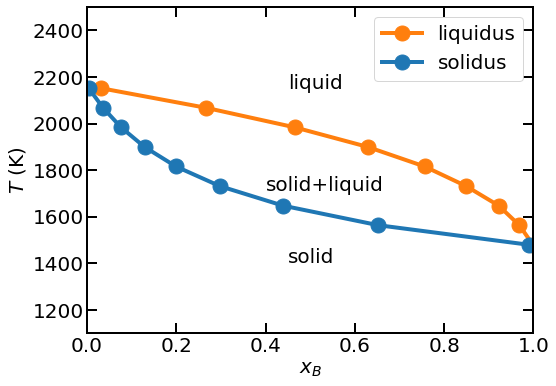

In [9]:
plt.rcParams.update({'figure.figsize':(8,6), 'font.size':20, \
                     'lines.linewidth':4, 'lines.markersize':15, 'axes.linewidth':2})
fig, ax = plt.subplots()
ax.plot(liquidus, Ts, '-o', c='C1', label='liquidus')
ax.plot(solidus, Ts, '-o', c='C0', label='solidus')
ax.annotate(s='solid', xy=(0.45, 1400))
ax.annotate(s='solid+liquid', xy=(0.4, 1710))
ax.annotate(s='liquid', xy=(0.45, 2150))
ax.tick_params(right=True, top=True, direction='in', length=10, width=2)
ax.set_xlim(0, 1)
ax.set_ylim(1100, 2500)
ax.set_xlabel(r'$x_{B}$')
ax.set_ylabel(r'$T$ (K)')
plt.legend()
plt.show()

## The appearance of the miscibility gap
But wait, there's more! By using much of the code we have already written and changing a few of the $\beta$ parameters, we can actually make a miscibility gap appear. In fact, many phase diagrams have both a miscibility gap and a solid+liquid region; they're usually not shown on the same plot because they're separated by a large temperature difference. This was one of many aspects of MATSCI 201A that blew my mind.

The miscibility gap arises at low temperatures in the regular solution model when the $\beta$ parameter is large. We'll find the common tangent on the $\Delta G^s$ curve, and the tangent points will demarcate the **solvus** surrounding the miscibility gap.

**TODO**: Please finish the following code. If you were able to successfully complete the lens diagram portion, then you should find this part to be even easier. Some hints are:
* Now we just have to compute one curve at each $T$ and find the common tangent with itself. You can read the `common_tangent()` function for more information on how this is implemented.
* You want to add **each** tangent point to the `solvus` list as a **separate tuple**, in the form `(x-coord, T)`

In [10]:
# New parameters and variables
beta_s = 11000
T_misc = 660 * np.array([0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1.0])
solvus = []

# ---------------------- #
# YOUR CODE HERE
for T in T_misc:
    ys = curve_s(x, T, beta_s)
    l, idmin, idmax = common_tangent(x, ys, ys, T, beta_s)
    solvus.append((x[idmin], T))
    solvus.append((x[idmax], T))
# ---------------------- #
solvus = sorted(solvus, key=lambda x: x[0])

In the last line above, we sort the points by increasing $x$-coordinate so that the dots are connected in sequence when we plot them. You should see a miscibility gap in the phase diagram below. Although the numbers are soemwhat fudged, they're still well within reason, suggesting how fundamentally related all these plots and concepts are.

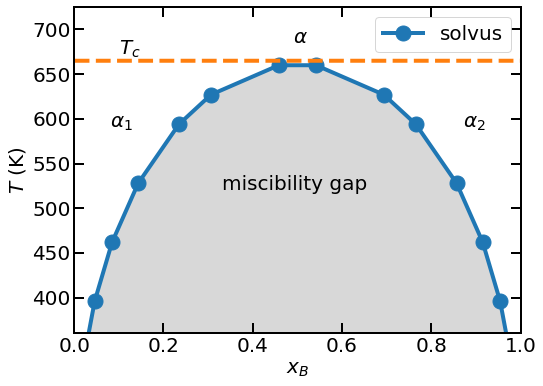

In [11]:
plt.rcParams.update({'figure.figsize':(8,6), 'font.size':20, \
                     'lines.linewidth':4, 'lines.markersize':15, 'axes.linewidth':2})
fig, ax = plt.subplots()
ax.plot(*zip(*solvus), '-o', label='solvus')
ax.fill_between(*zip(*solvus), color='C7', alpha=0.3)
ax.plot(x, 665 * np.ones(x.shape), ls='dashed')
ax.annotate(s=r'$T_c$', xy=(0.1, 672))
ax.annotate(s='miscibility gap', xy=(0.33, 520))
ax.annotate(s=r'$\alpha$', xy=(0.49, 685))
ax.annotate(s=r'$\alpha_1$', xy=(0.08, 590))
ax.annotate(s=r'$\alpha_2$', xy=(0.87, 590))
ax.tick_params(right=True, top=True, direction='in', length=10, width=2)
ax.set_xlim(0, 1)
ax.set_ylim(360, 725)
ax.set_xlabel(r'$x_{B}$')
ax.set_ylabel(r'$T$ (K)')
plt.legend()
plt.show()

## Conclusion
I hope this notebook helped you with visualizing the thermodynamics of ideal and regular solutions and gave you some Python practice. If you have any remaining questions or ideas for this and other modules, please don't hesitate to reach out.